In [91]:
import pandas as pd
from libpysal.cg import KDTree, RADIUS_EARTH_MILES
from libpysal.weights import KNN
from spreg import ML_Lag


import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import libpysal as lps
import pysal as ps

In [92]:
#read london borough
boros = gpd.read_file('statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

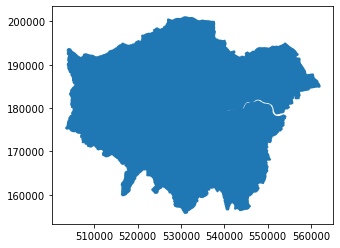

In [93]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
# buffer the boundary by 250m
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

In [94]:
green_acc = pd.read_csv("Data_firstclean/green_lsoa.csv",low_memory=False)

<AxesSubplot:>

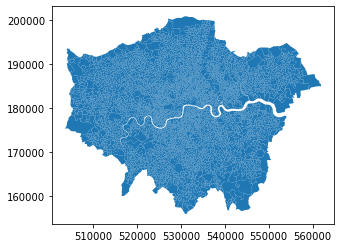

In [95]:
#lSOA Shapefile 
lsoas = gpd.read_file('statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp')
lsoas.plot()

In [96]:
lsoa_greenacc = pd.merge(lsoas, green_acc, left_on='LSOA11CD', right_on='lsoa11', how='left')
print(lsoa_greenacc.shape)

(4835, 19)


In [97]:
other = pd.read_csv("Data_firstclean/other_factors2.csv",low_memory=False)
other.head()

,Area_code,Area_name,obesity(age18+),respiratory,coronary,TB_incidence,Active,Females,Populationdensity,housingprice,...,65+(100%),All_persons,total_cases,ln_total_cases,total_cases2,covid0_60,covid_60up,total_case_rate,infection_tate(60-),infection_tate(60+)
0,E09000002,Barking and Dagenham,64.5155,133.0534,104.4367,20.6100,0.519,0.513476,6064.0,300000.0,...,0.086798,218900,71600,11.178850,27327,65036.0,6633.0,32.708999,34.050262,24.032533
1,E09000003,Barnet,61.1233,77.4378,88.5450,13.3525,0.616,0.516054,4487.0,533500.0,...,0.144105,389300,132459,11.794028,51285,115297.0,17370.0,34.024917,36.707100,23.098360
2,E09000004,Bexley,64.6095,88.3333,90.9369,8.8988,0.524,0.519270,4069.0,342500.0,...,0.166329,246500,85071,11.351241,35010,72806.0,12377.0,34.511562,37.939552,22.668429
3,E09000005,Brent,55.8951,72.4171,103.4684,32.5362,0.557,0.509417,7859.0,499950.0,...,0.116245,339800,106510,11.575994,40930,93742.0,12837.0,31.344909,33.019373,22.964174
4,E09000006,Bromley,58.0292,83.4814,80.1178,5.2376,0.683,0.520303,2198.0,440000.0,...,0.176667,330000,114402,11.647474,47084,98314.0,16263.0,34.667273,38.782643,21.231022


In [98]:
boro_green2 = lsoa_greenacc.groupby(['LAD11CD'],as_index=False)['blue_dist','green_act','green_pas'].median()

/tmp/ipykernel_257/1964027884.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  boro_green2 = lsoa_greenacc.groupby(['LAD11CD'],as_index=False)['blue_dist','green_act','green_pas'].median()


In [99]:
#add green space with borough file
boro_greenacc = pd.merge(boros, boro_green2, left_on='GSS_CODE', right_on='LAD11CD', how='left')
print(boro_greenacc.shape)
boro_greenacc

(33, 12)


,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,LAD11CD,blue_dist,green_act,green_pas
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,3.443026,0.51207,0.464815
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,2.908372,0.50500,0.584036
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,2.637000,0.47000,0.478473
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,1.598901,0.38250,0.564246
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,2.013571,0.37750,0.553855
5,Havering,E09000016,11445.735,210.763,F,None,None,"POLYGON ((549893.900 181459.800, 549894.600 18...",E09000016,1.899262,0.45000,0.647522
6,Hillingdon,E09000017,11570.063,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510615.200 19...",E09000017,2.395870,0.41000,0.466313
7,Harrow,E09000015,5046.330,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510660.000 19...",E09000015,2.618333,0.43000,0.321409
8,Brent,E09000005,4323.270,0.000,F,None,None,"POLYGON ((525201.000 182512.600, 525181.500 18...",E09000005,2.081429,0.38000,0.470558
9,Barnet,E09000003,8674.837,0.000,F,None,None,"POLYGON ((524579.900 198355.200, 524594.300 19...",E09000003,3.113437,0.44000,0.611714


In [100]:
#add green space with borough file
boro_xy = pd.merge(boro_greenacc,other, left_on="GSS_CODE", right_on='Area_code', how='inner')
boro_xy.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,LAD11CD,blue_dist,...,65+(100%),All_persons,total_cases,ln_total_cases,total_cases2,covid0_60,covid_60up,total_case_rate,infection_tate(60-),infection_tate(60+)
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,3.443026,...,0.144048,168000,63134,11.053015,25388,55474.0,7745.0,37.579762,40.910030,23.904215
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,2.908372,...,0.135875,390800,130320,11.777748,54280,113581.0,16970.0,33.346981,35.796092,23.119848
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,2.637000,...,0.176667,330000,114402,11.647474,47084,98314.0,16263.0,34.667273,38.782643,21.231022
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,1.598901,...,0.117974,288200,98773,11.500580,37581,87660.0,11146.0,34.272380,36.373444,23.564423
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,2.013571,...,0.121220,367100,124575,11.732663,47256,109930.0,14669.0,33.934895,36.054444,23.621532


In [101]:
print(type(boro_xy))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [102]:
print(type(boros))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [103]:
boro_xy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   NAME                 32 non-null     object  
 1   GSS_CODE             32 non-null     object  
 2   HECTARES             32 non-null     float64 
 3   NONLD_AREA           32 non-null     float64 
 4   ONS_INNER            32 non-null     object  
 5   SUB_2009             0 non-null      object  
 6   SUB_2006             0 non-null      object  
 7   geometry             32 non-null     geometry
 8   LAD11CD              32 non-null     object  
 9   blue_dist            32 non-null     float64 
 10  green_act            32 non-null     float64 
 11  green_pas            32 non-null     float64 
 12  Area_code            32 non-null     object  
 13  Area_name            32 non-null     object  
 14  obesity(age18+)      32 non-null     float64 
 15  respiratory      

In [104]:
#　空间权重设置

In [105]:
#pip install pysal

In [106]:
#pip install -i https://pypi.tuna.tsinghua.edu.cn/simple pysal

In [107]:
#import pysal

In [108]:
#pysal.open.check()

In [109]:
#add green space with borough file
boro_xy1 = pd.merge(other, boro_green2, left_on='Area_code', right_on='LAD11CD', how='left')
print(boro_xy1.shape)


(33, 25)


In [150]:
boro_xy.drop(["Area_name","LAD11CD","NAME"],axis=1, inplace=True)

KeyError: "['Area_name' 'LAD11CD' 'NAME'] not found in axis"

In [151]:
boro_xy2 = boro_xy[["obesity(age18+)","respiratory","coronary",
           "TB_incidence","Active","Females","income",
           "blue_dist","green_act","infection_tate(60+)",'total_case_rate','infection_tate(60-)']]
boro_xy2


,obesity(age18+),respiratory,coronary,TB_incidence,Active,Females,income,blue_dist,green_act,infection_tate(60+),total_case_rate,infection_tate(60-)
0,57.6050,83.2563,89.3540,8.9085,0.648,0.517857,616.9,3.443026,0.51207,23.904215,37.579762,40.910030
1,61.8092,96.4060,88.0417,18.0656,0.578,0.519447,564.8,2.908372,0.50500,23.119848,33.346981,35.796092
2,58.0292,83.4814,80.1178,5.2376,0.683,0.520303,608.4,2.637000,0.47000,21.231022,34.667273,38.782643
3,63.2337,95.9538,115.7913,32.0432,0.518,0.503123,522.3,1.598901,0.38250,23.564423,34.272380,36.373444
4,53.0091,89.0166,97.2686,34.1931,0.608,0.507491,574.9,2.013571,0.37750,23.621532,33.934895,36.054444
5,68.8159,102.1376,89.9348,6.5943,0.492,0.517557,574.9,1.899262,0.45000,23.372064,35.672137,39.401391
6,55.7376,98.4429,106.1528,22.5374,0.536,0.506048,559.0,2.395870,0.41000,23.460798,34.808434,37.383600
7,52.9619,70.0118,91.4054,29.0593,0.477,0.507080,566.7,2.618333,0.43000,23.539674,32.833525,35.312108
8,55.8951,72.4171,103.4684,32.5362,0.557,0.509417,540.7,2.081429,0.38000,22.964174,31.344909,33.019373
9,61.1233,77.4378,88.5450,13.3525,0.616,0.516054,520.2,3.113437,0.44000,23.098360,34.024917,36.707100


In [152]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [153]:
normed = boro_xy2.copy()
for c in boro_xy2.columns.values:
    normed[c] = rs.fit_transform(boro_xy2[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()

The range of obesity(age18+) is [-0.6712447166589165, 0.8120840702603035]
The range of respiratory is [-0.890298358487599, 1.3149396137058358]
The range of coronary is [-1.0204260777104195, 0.6342550673267853]
The range of TB_incidence is [-0.41980447396896653, 1.237964564737028]
The range of Active is [-0.7440000000000008, 0.6533333333333334]
The range of Females is [-0.8859431172553301, 0.8308969230021038]
The range of income is [-0.48143914652732434, 1.1302525582408016]
The range of blue_dist is [-0.6732576374732888, 1.054979414767489]
The range of green_act is [-0.7431102362204726, 0.5248818897637795]
The range of infection_tate(60+) is [-0.9301909756053459, 0.69378641069241]
The range of total_case_rate is [-1.0747108412200819, 0.7761515098656115]
The range of infection_tate(60-) is [-0.7996016315419437, 0.7706640064893725]


,obesity(age18+),respiratory,coronary,TB_incidence,Active,Females,income,blue_dist,green_act,infection_tate(60+),total_case_rate,infection_tate(60-)
0,0.142902,-0.193532,-0.107205,-0.259118,0.168000,0.096391,0.219083,0.841101,0.524882,0.389277,0.776152,0.770664
1,0.393852,0.204804,-0.142433,0.141718,-0.205333,0.174683,-0.064500,0.549105,0.497047,0.052077,-0.322478,-0.188817
2,0.168222,-0.186713,-0.355144,-0.419804,0.354667,0.216815,0.172817,0.400898,0.359252,-0.759933,0.020208,0.371522
3,0.478881,0.191105,0.602485,0.753562,-0.525333,-0.629055,-0.295831,-0.166050,0.014764,0.243200,-0.082288,-0.080494
4,-0.131429,-0.019039,0.105256,0.847670,-0.045333,-0.413980,-0.009525,0.060418,-0.004921,0.267751,-0.169883,-0.140345


In [154]:
#wq = pysal.Queen.from_shapefile("boro_xy")#使用Quuen式邻接矩阵
#wq.transform = 'r'
wq = lps.weights.Queen.from_dataframe(boro_xy)#使用Quuen式邻接矩阵
wq.transform = 'r'

### covid cases  60+

In [155]:
y_name = "infection_tate(60+)"
#y = np.array (boro_xy[y_name]).T

In [156]:
y = normed['infection_tate(60+)']

In [157]:
y=y.to_numpy()
y.shape = (32,1)

In [158]:
y.shape

(32, 1)

In [159]:
x_names = ["obesity(age18+)","respiratory","coronary",
           "TB_incidence","Active","Females","income",
           "blue_dist","green_act"]


In [160]:
x = normed[x_names]
x=x.to_numpy()

In [161]:
x.shape

(32, 9)

In [162]:
from spreg import ML_Lag

In [163]:
reg1= ML_Lag(y,x,wq,name_y= y_name,name_x = x_names, name_w = 'queen',name_ds= 'NAT')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/scipy/optimize/_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [164]:
"""splag = spreg.ML_Lag(y,x,w_queen,name_y='ridership',name_x=list(var_3.columns),name_ds='DIDI_chengdu',name_w='queen')
print(splag.summary)l
r = spreg.diagnostics.likratiotest(ols,splag)"""

"splag = spreg.ML_Lag(y,x,w_queen,name_y='ridership',name_x=list(var_3.columns),name_ds='DIDI_chengdu',name_w='queen')\nprint(splag.summary)l\nr = spreg.diagnostics.likratiotest(ols,splag)"

In [165]:
print (reg1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :         NAT
Weights matrix      :       queen
Dependent Variable  :infection_tate(60+)                Number of Observations:          32
Mean dependent var  :     -0.0552                Number of Variables   :          11
S.D. dependent var  :      0.3892                Degrees of Freedom    :          21
Pseudo R-squared    :      0.5620
Spatial Pseudo R-squared:  0.5551
Sigma-square ML     :       0.064                Log likelihood        :      -1.832
S.E of regression   :       0.254                Akaike info criterion :      25.664
                                                 Schwarz criterion     :      41.787

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------

In [61]:
#DF = reg1.summary

In [73]:
#import io
#df = pd.read_csv(io.StringIO(DF), lineterminator='/')


,REGRESSION\n----------\nSUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)\n-----------------------------------------------------------------\nData set : NAT\nWeights matrix : queen\nDependent Variable :infection_tate(60+) Number of Observations: 32\nMean dependent var : 22.8704 Number of Variables : 11\nS.D. dependent var : 0.9054 Degrees of Freedom : 21\nPseudo R-squared : 0.5620\nSpatial Pseudo R-squared: 0.5551\nSigma-square ML : 0.348 Log likelihood : -28.846\nS.E of regression : 0.590 Akaike info criterion : 79.693\n Schwarz criterion : 95.816\n\n------------------------------------------------------------------------------------\n Variable Coefficient Std.Error z-Statistic Probability\n------------------------------------------------------------------------------------\n CONSTANT 15.6944282 12.7896788 1.2271167 0.2197787\n obesity(age18+) -0.0051781 0.0310788 -0.1666118 0.8676755\n respiratory 0.0089650 0.0103527 0.8659619 0.3865111\n coronary 0.0294198 0.0138128 2.1298847 0.0331811\n TB_incidence 0.0146151 0.0194913 0.7498272 0.4533588\n Active -1.5847633 2.5508578 -0.6212668 0.5344241\n Females -9.8506713 21.7067930 -0.4538059 0.6499685\n income 0.0036223 0.0024934 1.4527331 0.1462979\n blue_dist 0.0470850 0.2182897 0.2156997 0.8292219\n green_act 3.0918815 2.2550869 1.3710698 0.1703532\nW_infection_tate(60+) 0.2762115 0.1846846 1.4955849 0.1347619\n------------------------------------------------------------------------------------\n================================ END OF REPORT =====================================


,REGRESSION\n----------\nSUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)\n-----------------------------------------------------------------\nData set : NAT\nWeights matrix : queen\nDependent Variable :infection_tate(60+) Number of Observations: 32\nMean dependent var : 22.8704 Number of Variables : 11\nS.D. dependent var : 0.9054 Degrees of Freedom : 21\nPseudo R-squared : 0.5620\nSpatial Pseudo R-squared: 0.5551\nSigma-square ML : 0.348 Log likelihood : -28.846\nS.E of regression : 0.590 Akaike info criterion : 79.693\n Schwarz criterion : 95.816\n\n------------------------------------------------------------------------------------\n Variable Coefficient Std.Error z-Statistic Probability\n------------------------------------------------------------------------------------\n CONSTANT 15.6944282 12.7896788 1.2271167 0.2197787\n obesity(age18+) -0.0051781 0.0310788 -0.1666118 0.8676755\n respiratory 0.0089650 0.0103527 0.8659619 0.3865111\n coronary 0.0294198 0.0138128 2.1298847 0.0331811\n TB_incidence 0.0146151 0.0194913 0.7498272 0.4533588\n Active -1.5847633 2.5508578 -0.6212668 0.5344241\n Females -9.8506713 21.7067930 -0.4538059 0.6499685\n income 0.0036223 0.0024934 1.4527331 0.1462979\n blue_dist 0.0470850 0.2182897 0.2156997 0.8292219\n green_act 3.0918815 2.2550869 1.3710698 0.1703532\nW_infection_tate(60+) 0.2762115 0.1846846 1.4955849 0.1347619\n------------------------------------------------------------------------------------\n================================ END OF REPORT =====================================


In [166]:
import spreg

In [167]:
ols = spreg.OLS(y,x,wq,spat_diag=True,moran=True,name_y= y_name,name_x = x_names,name_ds='OLS 60+',name_w='queen')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     OLS 60+
Weights matrix      :       queen
Dependent Variable  :infection_tate(60+)                Number of Observations:          32
Mean dependent var  :     -0.0552                Number of Variables   :          10
S.D. dependent var  :      0.3892                Degrees of Freedom    :          22
R-squared           :      0.5230
Adjusted R-squared  :      0.3278
Sum squared residual:       2.240                F-statistic           :      2.6801
Sigma-square        :       0.102                Prob(F-statistic)     :     0.02859
S.E. of regression  :       0.319                Log likelihood        :      -2.859
Sigma-square ML     :       0.070                Akaike info criterion :      25.717
S.E of regression ML:      0.2646                Schwarz criterion     :      40.375

----------------------------------------------------------------------

In [168]:
from spreg import GM_Error

In [169]:
reg1b= GM_Error(y,x,wq,name_y= y_name,name_x = x_names, name_w = 'nat_queen.gal',name_ds= 'NAT')
print (reg1b.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :         NAT
Weights matrix      :nat_queen.gal
Dependent Variable  :infection_tate(60+)                Number of Observations:          32
Mean dependent var  :     -0.0552                Number of Variables   :          10
S.D. dependent var  :      0.3892                Degrees of Freedom    :          22
Pseudo R-squared    :      0.5218

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0876954       0.0655442      -1.3379581       0.1809101
     obesity(age18+)      -0.0630241       0.2290039      -0.2752098       0.7831550
         respiratory       0.1861835       0.1492451       1.2475017       0.212213

###  total covid cases 

In [170]:
y_name = "total_case_rate"
#y = np.array (boro_xy[y_name]).T

In [171]:
y = normed['total_case_rate']

In [172]:
y=y.to_numpy()
y.shape = (32,1)

In [173]:
y.shape

(32, 1)

In [174]:
reg1= ML_Lag(y,x,wq,name_y= y_name,name_x = x_names, name_w = 'queen',name_ds= 'NAT')
print (reg1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :         NAT
Weights matrix      :       queen
Dependent Variable  :total_case_rate                Number of Observations:          32
Mean dependent var  :     -0.0248                Number of Variables   :          11
S.D. dependent var  :      0.4630                Degrees of Freedom    :          21
Pseudo R-squared    :      0.5923
Spatial Pseudo R-squared:  0.5501
Sigma-square ML     :       0.085                Log likelihood        :      -6.238
S.E of regression   :       0.291                Akaike info criterion :      34.476
                                                 Schwarz criterion     :      50.599

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------

In [175]:
ols = spreg.OLS(y,x,wq,spat_diag=True,moran=True,name_y= y_name,name_x = x_names,name_ds='OLS 60+',name_w='queen')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     OLS 60+
Weights matrix      :       queen
Dependent Variable  :total_case_rate                Number of Observations:          32
Mean dependent var  :     -0.0248                Number of Variables   :          10
S.D. dependent var  :      0.4630                Degrees of Freedom    :          22
R-squared           :      0.5552
Adjusted R-squared  :      0.3732
Sum squared residual:       2.955                F-statistic           :      3.0511
Sigma-square        :       0.134                Prob(F-statistic)     :     0.01578
S.E. of regression  :       0.367                Log likelihood        :      -7.292
Sigma-square ML     :       0.092                Akaike info criterion :      34.584
S.E of regression ML:      0.3039                Schwarz criterion     :      49.242

--------------------------------------------------------------------------

In [176]:
reg1b= GM_Error(y,x,wq,name_y= y_name,name_x = x_names, name_w = 'nat_queen.gal',name_ds= 'NAT')
print (reg1b.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :         NAT
Weights matrix      :nat_queen.gal
Dependent Variable  :total_case_rate                Number of Observations:          32
Mean dependent var  :     -0.0248                Number of Variables   :          10
S.D. dependent var  :      0.4630                Degrees of Freedom    :          22
Pseudo R-squared    :      0.5377

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0333434       0.0843853      -0.3951335       0.6927444
     obesity(age18+)       0.2998273       0.2434857       1.2313960       0.2181748
         respiratory      -0.0846244       0.1661173      -0.5094256       0.6104540
  

###   covid cases (0-59)

In [178]:
y_name = "infection_tate(60-)"
#y = np.array (boro_xy[y_name]).T

In [179]:
y = normed['infection_tate(60-)']

In [180]:
y=y.to_numpy()
y.shape = (32,1)

In [181]:
y.shape

(32, 1)

In [182]:
reg1= ML_Lag(y,x,wq,name_y= y_name,name_x = x_names, name_w = 'queen',name_ds= 'NAT')
print (reg1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :         NAT
Weights matrix      :       queen
Dependent Variable  :infection_tate(60-)                Number of Observations:          32
Mean dependent var  :      0.0104                Number of Variables   :          11
S.D. dependent var  :      0.4102                Degrees of Freedom    :          21
Pseudo R-squared    :      0.6331
Spatial Pseudo R-squared:  0.5981
Sigma-square ML     :       0.060                Log likelihood        :      -0.642
S.E of regression   :       0.245                Akaike info criterion :      23.285
                                                 Schwarz criterion     :      39.408

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------

In [183]:
ols = spreg.OLS(y,x,wq,spat_diag=True,moran=True,name_y= y_name,name_x = x_names,name_ds='OLS 60+',name_w='queen')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     OLS 60+
Weights matrix      :       queen
Dependent Variable  :infection_tate(60-)                Number of Observations:          32
Mean dependent var  :      0.0104                Number of Variables   :          10
S.D. dependent var  :      0.4102                Degrees of Freedom    :          22
R-squared           :      0.5992
Adjusted R-squared  :      0.4352
Sum squared residual:       2.091                F-statistic           :      3.6540
Sigma-square        :       0.095                Prob(F-statistic)     :    0.006296
S.E. of regression  :       0.308                Log likelihood        :      -1.753
Sigma-square ML     :       0.065                Akaike info criterion :      23.506
S.E of regression ML:      0.2556                Schwarz criterion     :      38.163

----------------------------------------------------------------------

In [184]:
reg1b= GM_Error(y,x,wq,name_y= y_name,name_x = x_names, name_w = 'nat_queen.gal',name_ds= 'NAT')
print (reg1b.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :         NAT
Weights matrix      :nat_queen.gal
Dependent Variable  :infection_tate(60-)                Number of Observations:          32
Mean dependent var  :      0.0104                Number of Variables   :          10
S.D. dependent var  :      0.4102                Degrees of Freedom    :          22
Pseudo R-squared    :      0.5778

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.0382197       0.0733528       0.5210396       0.6023392
     obesity(age18+)       0.2822670       0.2002646       1.4094705       0.1586961
         respiratory      -0.1751025       0.1381693      -1.2673039       0.205046